In [1]:
!echo $PYTHONPATH
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

%load_ext autoreload
%autoreload 2
%matplotlib inline

/home/dianloo/Desktop/tesi/quilt


In [2]:
from quilt.builder import NeuronCatalogue, SpikingNetwork

catalogue = NeuronCatalogue.from_yaml("tests/basal_ganglia_neurons.yaml")

Loaded model for neuron 'D1_neuron'

Loaded model for neuron 'D2_neuron'

Loaded model for neuron 'FSN_neuron'

Loaded model for neuron 'GPeTA_neuron'

Loaded model for neuron 'GPeTI_neuron'

Loaded model for neuron 'STN_neuron'

Loaded model for neuron 'SNR_neuron'

In [3]:
sn = SpikingNetwork.from_yaml("tests/basal_ganglia_network.yaml", catalogue)
sn.rescale_populations(0.5)
sn.rescale_connectivity(1.0)
sn.rescale_weights(1)
sn.rescale_delays(1)
sn.build()

Output()

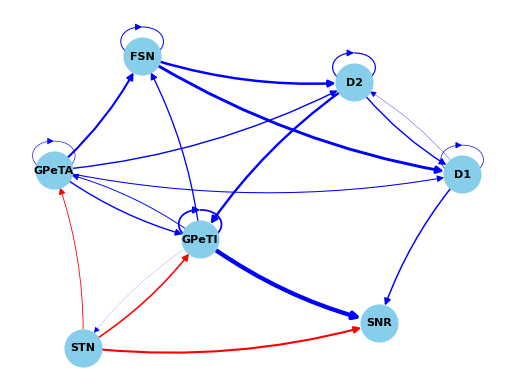

In [4]:
from quilt.view import plot_graph
fig, ax = plt.subplots()
plot_graph(sn)

## Input/Output

In [5]:
pop_state_monitorized = "SNR"
for population in sn.populations.values():
    population.monitorize_spikes()
# sn.populations[pop_state_monitorized].monitorize_states()

In [6]:
poisson_rescale = 1.0
poisson_inputs = dict(STN   = [500, 0.25],
                      GPeTA = [170, 0.15],
                      GPeTI = [1530*0.25, 0.25 ],
                      FSN   = [944.4, 0.5],
                      SNR   = [600, 0.55]
                    )

for pi in poisson_inputs.values():
    pi[1] *= poisson_rescale
    
for pop in poisson_inputs:
    sn.populations[pop].add_poisson_spike_injector(*poisson_inputs[pop])

sn.populations["D1"].add_poisson_spike_injector(poisson_rescale * 1120, 0.45)
sn.populations["D2"].add_poisson_spike_injector(poisson_rescale * 972.927, 0.45) 

In [7]:
sn.run(dt=0.1, time=8000)

Running network consisting of 14622 neurons for 80000 timesteps

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************
Simulation took 120 s	(1.50422 ms/step)
	Gathering time avg: 0.037975 us/step
	Inject time avg: 130.968 us/step
Population evolution stats:
	0:
		evolution:	395.667 us/step	65 ns/step/neuron
		spike emission:	54.1504 us/step	9 ns/step/neuron
	1:
		evolution:	374.258 us/step	62 ns/step/neuron
		spike emission:	76.8787 us/step	12 ns/step/neuron
	2:
		evolution:	79.9515 us/step	190 ns/step/neuron
		spike emission:	14.9977 us/step	35 ns/step/neuron
	3:
		evolution:	100.805 us/step	129 ns/step/neuron
		spike emission:	25.4878 us/step	32 ns/step/neuron
	4:
		evolution:	59.9475 us/step	230 ns/step/neuron
		spike emission:	6.72368 us/step	25 ns/step/neuron
	5:
		evolution:	70.1414 us/step	171 ns/step/neuron
		spike emission:	5.66149 us/step	13 ns/step/neuron
	6:
		evolution

In [8]:
spikes = dict()
for pop in sn.populations.keys():
    spikes[pop] = sn.populations[pop].get_data()['spikes']

# states = sn.populations[pop_state_monitorized].get_data()['states']

Mean firing rate D1:	2.0 Hz
Mean firing rate D2:	2.3 Hz
Mean firing rate FSN:	24.6 Hz
Mean firing rate GPeTI:	95.1 Hz
Mean firing rate GPeTA:	14.4 Hz
Mean firing rate STN:	18.4 Hz
Mean firing rate SNR:	0.0 Hz


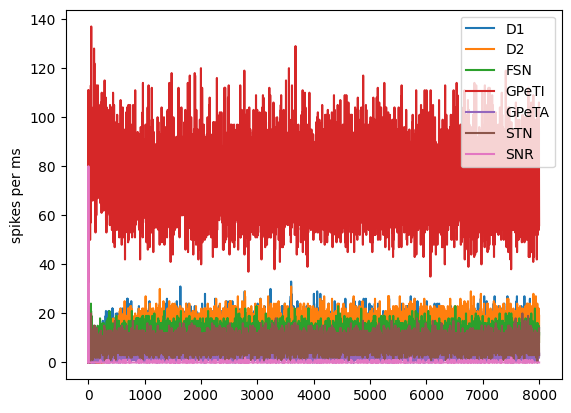

In [9]:
fig, ax = plt.subplots()
timesteps_per_bin = 10
binned_signals = dict()

for pop in spikes.keys():
    binned_signals[pop] = np.sum( 
                            spikes[pop][:(len(spikes[pop])//timesteps_per_bin)*timesteps_per_bin].reshape(-1, timesteps_per_bin),
                            axis=1).squeeze()
    
    mfr = np.mean(binned_signals[pop][200:]) * 1e3 / sn.populations[pop].n_neurons
    print(f"Mean firing rate {pop}:\t{mfr:.1f} Hz")
    plt.plot(binned_signals[pop], label=pop)
             
plt.legend()
plt.ylabel("spikes per ms");


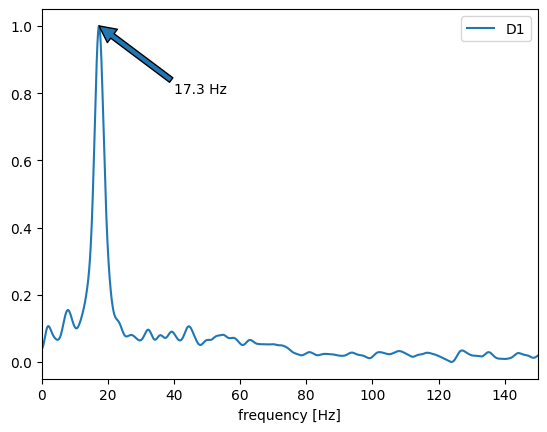

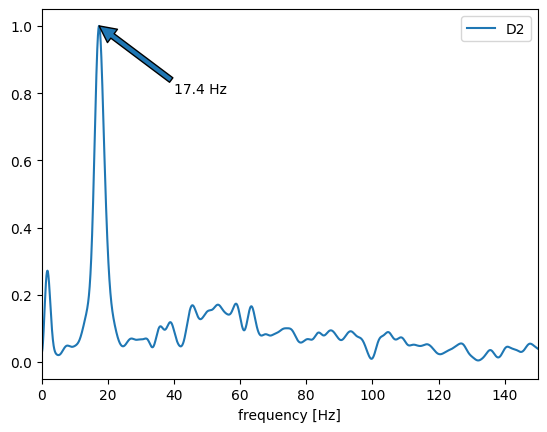

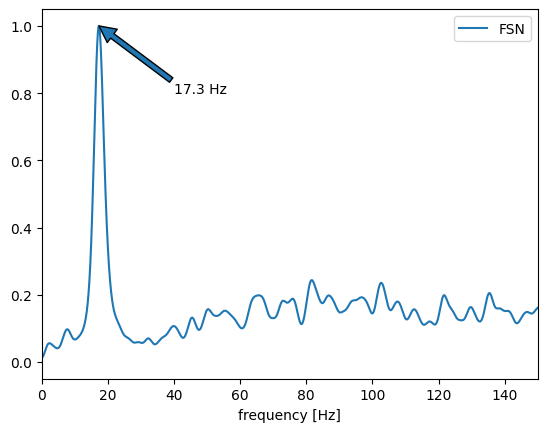

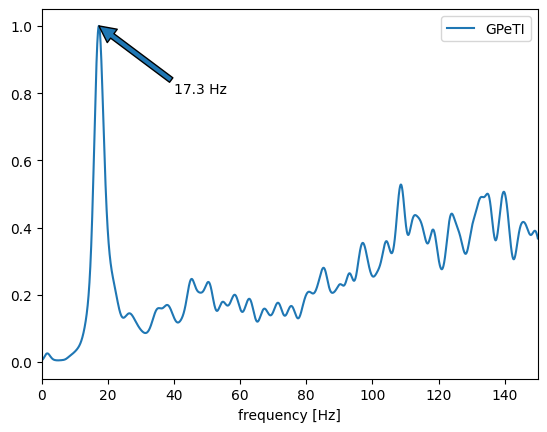

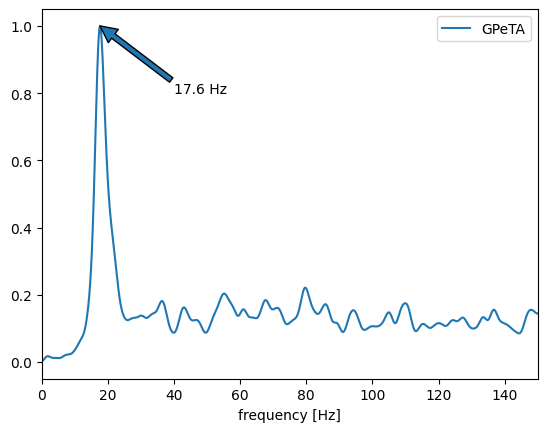

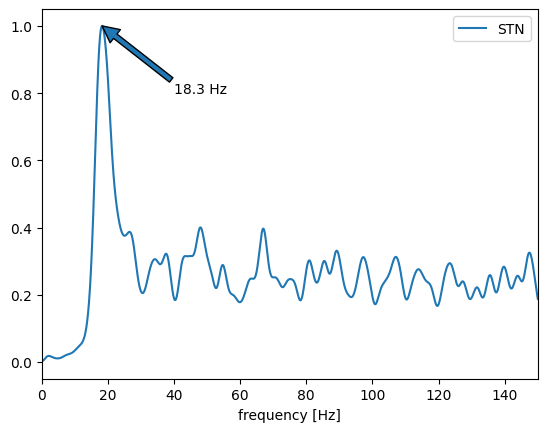

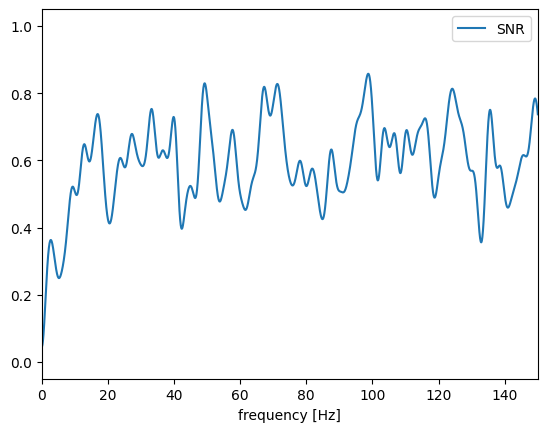

In [24]:
from numpy.fft import fft, fftfreq
from scipy.signal import welch
from sklearn.preprocessing import MinMaxScaler
from neurodsp.filt import filter_signal

fig, ax = plt.subplots()
scaler = MinMaxScaler()

burn_in = 200

for pop in sn.populations.keys():
    signal = binned_signals[pop][burn_in:]
    # signal = butter_bandpass_filter(signal, 0.2, 80, 1000, order=4)
    # fig, ax = plt.subplots()
    f, PSD = welch(signal, 
                   1000, 
                   nperseg=500, 
                   noverlap=250,
                   nfft=30000,#None, 
                   scaling='density', 
                   window='hamming')
    # print(PSD)
    plt.plot(f, scaler.fit_transform(PSD[:, None]).squeeze(), label=pop)
    # plt.plot(f, PSD, label=pop)
    plt.annotate(f"{f[np.argmax(PSD)]:.1f} Hz", xy=(f[np.argmax(PSD)], 1), xytext= (40, 0.8), arrowprops=dict())
    plt.legend()
    plt.xlim(0,150)
    plt.xlabel("frequency [Hz]")

    plt.show()
    # break
# plt.xlim([0,50]);


In [18]:
plt.annotate?

Signature:
plt.annotate(
    text: 'str',
    xy: 'tuple[float, float]',
    xytext: 'tuple[float, float] | None' = None,
    xycoords: 'str | Artist | Transform | Callable[[RendererBase], Bbox | Transform] | tuple[float, float]' = 'data',
    textcoords: 'str | Artist | Transform | Callable[[RendererBase], Bbox | Transform] | tuple[float, float] | None' = None,
    arrowprops: 'dict[str, Any] | None' = None,
    annotation_clip: 'bool | None' = None,
    **kwargs,
) -> 'Annotation'
Docstring:
Annotate the point *xy* with text *text*.

In the simplest form, the text is placed at *xy*.

Optionally, the text can be displayed in another position *xytext*.
An arrow pointing from the text to the annotated point *xy* can then
be added by defining *arrowprops*.

Parameters
----------
text : str
    The text of the annotation.

xy : (float, float)
    The point *(x, y)* to annotate. The coordinate system is determined
    by *xycoords*.

xytext : (float, float), default: *xy*
    The position 

In [11]:
# fig,ax = plt.subplots()
# plt.plot(np.mean(states[:, :, 0], axis=1))
# plt.title(pop_state_monitorized+"V")
# # plt.xlim(0,1000)

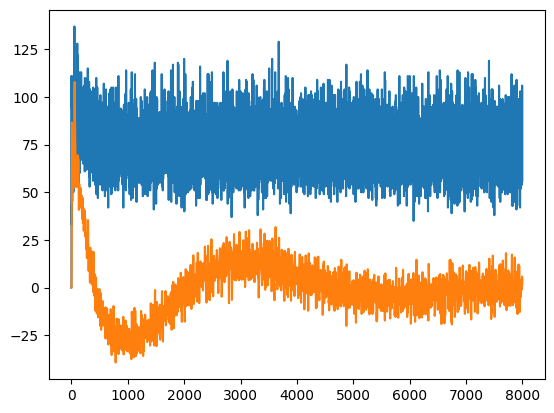

In [12]:
fig,ax = plt.subplots()
plt.plot(states[:, 5, 0])
plt.plot(np.mean(states[:, :, 0], axis=1))
plt.title(pop_state_monitorized+" - V")
# plt.xlim(0,1000)

In [ ]:
from scipy.signal import butter, lfilter


from scipy.signal import butter, lfilter, freqz

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    # low = lowcut / nyquist
    # high = highcut / nyquist
    low = lowcut
    high = highcut
    b, a = butter(order, [low, high], fs=fs, btype='band', analog=False)
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y
    
pop = "GPeTI"

plt.plot(binned_signals[pop])
plt.plot(butter_bandpass_filter(binned_signals[pop], 0.2, 80, 1000, order=4))
# plt.ylim(-11250,11250)